# Introduction

This is my attempt at learning time series prediction using the most upvoted kernel in here. The aim is divided into two parts:

1. Perform EDA on WW2 dataset
2. Learn Time Series Prediction from this [kernel](https://www.kaggle.com/kanncaa1/time-series-prediction-tutorial-with-eda)



## EDA of WW2 weather & bombing dataset
Performing data analysis of the weather dataset.
### Importing necessary modules

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
from tabulate import tabulate
# ignore filters
warnings.filterwarnings("ignore")
# set plot style to ggplot
plt.style.use('ggplot')

In [26]:
print(os.listdir("../input/world-war-ii"))
print(os.listdir("../input/weatherww2"))

['operations.csv']
['Weather Station Locations.csv', 'Summary of Weather.csv']


### Loading dataset + printing overviews

In [27]:
def overview():
    """
    Reads the dataframe stored in the csv, prints overview such as head, dtypes, null values count, summary.
    Returns: the dataframe
    """
    bomb_df = pd.read_csv("../input/world-war-ii/operations.csv")
    bomb_df.name = 'Bombing operations'
    summary_df = pd.read_csv("../input/weatherww2/Summary of Weather.csv")
    summary_df.name = 'Summary of WW2 weather'
    stations_df = pd.read_csv("../input/weatherww2/Weather Station Locations.csv")
    stations_df.name = 'WW2 Weather Station Locations'
    datasets = (bomb_df, summary_df, stations_df)
    for df in datasets:
        print("\nPrinting summary for the dataset:", df.name)
        print("\nThe shape of the data is:")
        print(df.shape)
        print("\nThe dtypes of columns are:")
        print(df.dtypes)
        print("\nThe null values in each column are:")
        print(df.isnull().sum())
        print("\nThe first 5 rows of the data are:")
        print(df.head())
        print("\nThe summary of the data is:")
        print(df.describe())
        
    return bomb_df, summary_df, stations_df

bombs_df, summary_df, stations_df = overview()
    


Printing summary for the dataset: Bombing operations

The shape of the data is:
(178281, 46)

The dtypes of columns are:
Mission ID                                 int64
Mission Date                              object
Theater of Operations                     object
Country                                   object
Air Force                                 object
Unit ID                                   object
Aircraft Series                           object
Callsign                                  object
Mission Type                              object
Takeoff Base                              object
Takeoff Location                          object
Takeoff Latitude                          object
Takeoff Longitude                        float64
Target ID                                 object
Target Country                            object
Target City                               object
Target Type                               object
Target Industry                           obj

STA                 0
Date                0
Precip              0
WindGustSpd    118508
MaxTemp             0
MinTemp             0
MeanTemp            0
Snowfall         1163
PoorWeather     84803
YR                  0
MO                  0
DA                  0
PRCP             1932
DR             118507
SPD            118508
MAX               474
MIN               468
MEA               498
SNF              1163
SND            113477
FT             119040
FB             119040
FTI            119040
ITH            119040
PGT            118515
TSHDSBRSGF      84803
SD3            119040
RHX            119040
RHN            119040
RVG            119040
WTE            119040
dtype: int64

The first 5 rows of the data are:
     STA      Date Precip  WindGustSpd    MaxTemp    MinTemp   MeanTemp  \
0  10001  1942-7-1  1.016          NaN  25.555556  22.222222  23.888889   
1  10001  1942-7-2      0          NaN  28.888889  21.666667  25.555556   
2  10001  1942-7-3   2.54          NaN  26.11

### Data Description
* Bombing Operations
    * Mission ID, Mission Date - details of mission
    * Theater of Operations - Region in which active military operations are present
    * Country - Country which has undertaken the mission.
    * Air Force, Unit ID - The unit of the country's air force.
    * Aircraft Series - Model of aircraft used.
    * Callsign - Before attack, message, annoucement, tune that is broadcasted.
    * Take off Base, Location, Latitude, Longitude - Takeoff details
    * Target Country, City, Type, Industry, Priority, Latitude, Longitude - Target details
   
   
* Weather Conditions
    * Summary of WW2 weather
        * STA - station ID
        * Date 
        * Precip - Precipitation value
        * WindGustSpd - Wind speed
        * MaxTemp, MinTemp, MeanTemp - Temperature details for particular day
    * Weather Station Locations
        * WBAN - Weather station number
        * NAME, STATE/COUNTRY ID, LAT, LONG - station geographical details.

### Data Cleaning
* Bombing Operations
    * Data contains lot of NaN values, dropping the NaN values from redundant columns.
    * Drop countries that are NaN
    * Drop if longitude, latitude is NaN
    * Drop unused columns





In [28]:
aerial = bombs_df.iloc[:,0:21]
aerial = aerial.drop('Callsign', axis=1)
aerial = aerial.dropna(subset=['Theater of Operations', 'Country', 'Takeoff Longitude', 'Takeoff Latitude'])
print(aerial.dtypes)
print(aerial.shape)
print(aerial.isnull().sum())

Mission ID                 int64
Mission Date              object
Theater of Operations     object
Country                   object
Air Force                 object
Unit ID                   object
Aircraft Series           object
Mission Type              object
Takeoff Base              object
Takeoff Location          object
Takeoff Latitude          object
Takeoff Longitude        float64
Target ID                 object
Target Country            object
Target City               object
Target Type               object
Target Industry           object
Target Priority           object
Target Latitude          float64
Target Longitude         float64
dtype: object
(2783, 20)
Mission ID                  0
Mission Date                0
Theater of Operations       0
Country                     0
Air Force                  50
Unit ID                    80
Aircraft Series            30
Mission Type             2246
Takeoff Base                0
Takeoff Location            0
Takeoff Latitud

* Weather Summary
    * Selecting columns - 'STA', 'Date', 'Precip', 'WindGustSpd','Max Temp', 'Min Temp', 'Mean Temp', 'Snowfall', 'PoorWeather', 'YR', 'MO','DA', 'PRCP'

In [29]:
columns = ['STA', 'Date', 'Precip','MaxTemp', 'MinTemp', 'MeanTemp', 'Snowfall', 'YR', 'MO','DA', 'PRCP']
weather_df = summary_df[columns]
weather_df.isnull().sum()

STA            0
Date           0
Precip         0
MaxTemp        0
MinTemp        0
MeanTemp       0
Snowfall    1163
YR             0
MO             0
DA             0
PRCP        1932
dtype: int64

### Dealing with outliers


In [30]:
from scipy import stats
standardised = weather_df.groupby('STA')[['MeanTemp']].transform(stats.zscore)
outliers = standardised['MeanTemp'] > 3
# printing the outliers
print(weather_df.loc[outliers])

          STA       Date  Precip    MaxTemp    MinTemp   MeanTemp Snowfall  \
1469    10002  1944-4-18       0  32.777778  26.666667  30.000000        0   
1802    10002  1945-3-17       0  32.222222  27.222222  30.000000        0   
4395    10502  1942-8-30  27.686  36.666667  22.222222  29.444444        0   
9634    10704   1944-4-6       T  33.333333  23.888889  28.888889        0   
9637    10704   1944-4-9       0  33.888889  24.444444  28.888889        0   
9642    10704  1944-4-14       0  33.333333  23.888889  28.888889        0   
10000   10704   1945-4-7       0  35.000000  23.888889  29.444444        0   
15252   10804   1942-4-5       0  37.222222  26.111111  31.666667        0   
27122   11701   1944-7-5       0  37.777778  27.222222  32.222222        0   
29739   11801  1944-5-24       0  36.111111  25.555556  31.111111        0   
29740   11801  1944-5-25   0.508  36.666667  26.111111  31.111111        0   
51399   20602  1945-9-12       0  30.555556  26.666667  31.66666

#### Weather Station and Weather Summary Merge data, on = 'Station ID'

In [31]:
weather_df['STA'].unique()


array([10001, 10002, 10101, 10102, 10502, 10505, 10701, 10703, 10704,
       10705, 10718, 10802, 10803, 10804, 10806, 10807, 11101, 11103,
       11501, 11601, 11604, 11606, 11610, 11615, 11701, 11704, 11801,
       11901, 11902, 12001, 12101, 12701, 12702, 12706, 12801, 13002,
       13005, 13007, 13013, 13201, 13601, 15027, 16101, 16201, 16202,
       16405, 16407, 16504, 20501, 20602, 21501, 22502, 22504, 22507,
       22508, 22509, 30001, 31001, 31101, 31302, 31401, 31501, 31701,
       32301, 32501, 32503, 32504, 32601, 32602, 32603, 32701, 32702,
       32801, 32803, 32805, 32812, 32815, 32904, 32906, 32907, 33003,
       33013, 33014, 33019, 33023, 33031, 33044, 33109, 33111, 33117,
       33121, 33123, 33205, 33206, 33303, 33305, 33307, 33401, 33405,
       33406, 33501, 34002, 34003, 34005, 34012, 34013, 34017, 34018,
       34022, 34101, 34104, 34105, 34109, 34111, 34113, 34123, 34139,
       34147, 34150, 40601, 41204, 41207, 42204, 42206, 42401, 43201,
       43302, 43305,

In [32]:
np.sort(stations_df['WBAN'].unique())

array([10001, 10002, 10101, 10102, 10502, 10505, 10701, 10703, 10704,
       10705, 10718, 10802, 10803, 10804, 10806, 10807, 11101, 11103,
       11501, 11601, 11604, 11606, 11610, 11615, 11701, 11704, 11801,
       11901, 11902, 12001, 12101, 12701, 12702, 12706, 12801, 13002,
       13005, 13007, 13013, 13201, 13601, 15027, 15604, 15605, 16101,
       16201, 16202, 16405, 16407, 16504, 20501, 20602, 21501, 22502,
       22504, 22507, 22508, 22509, 30001, 31001, 31101, 31302, 31401,
       31501, 31701, 32301, 32501, 32503, 32504, 32601, 32602, 32603,
       32701, 32702, 32801, 32803, 32805, 32812, 32815, 32904, 32906,
       32907, 33003, 33013, 33014, 33019, 33023, 33031, 33044, 33109,
       33111, 33117, 33121, 33123, 33205, 33206, 33303, 33305, 33307,
       33401, 33405, 33406, 33501, 34002, 34003, 34005, 34012, 34013,
       34017, 34018, 34022, 34101, 34104, 34105, 34109, 34111, 34113,
       34123, 34139, 34147, 34150, 40601, 41204, 41207, 42204, 42206,
       42401, 43201,

In [33]:
weather = pd.merge(stations_df, weather_df, left_on='WBAN', right_on='STA', how='outer')
print(weather.head())
print(weather.shape)

    WBAN    NAME STATE/COUNTRY ID    LAT     LON  ELEV   Latitude  Longitude  \
0  33013  AIN EL               AL  3623N  00637E   611  36.383333       6.65   
1  33013  AIN EL               AL  3623N  00637E   611  36.383333       6.65   
2  33013  AIN EL               AL  3623N  00637E   611  36.383333       6.65   
3  33013  AIN EL               AL  3623N  00637E   611  36.383333       6.65   
4  33013  AIN EL               AL  3623N  00637E   611  36.383333       6.65   

       STA       Date Precip    MaxTemp   MinTemp   MeanTemp Snowfall    YR  \
0  33013.0  1943-3-11      0  15.555556  2.777778   8.888889        0  43.0   
1  33013.0  1943-3-12      0  12.777778  4.444444   8.888889        0  43.0   
2  33013.0  1943-3-13      0  17.222222  2.777778  10.000000        0  43.0   
3  33013.0  1943-3-14      0  10.000000  7.222222   8.888889        0  43.0   
4  33013.0  1943-3-15      0  14.444444  5.555556  10.000000        0  43.0   

    MO    DA PRCP  
0  3.0  11.0  NaN  
1  3

### Data Visualisation

We want to get following information from visualising the data.
* Aerial Bombing Countries
* Take off locations
* Target Country
* Top Aircrafts
* Weather stations location
* Theatre of operations
* Bombing path
* Weather patterns (Temp, Precipitation, Snowfall) throughout the WW2

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40]),
 <a list of 41 Text major ticklabel objects>)

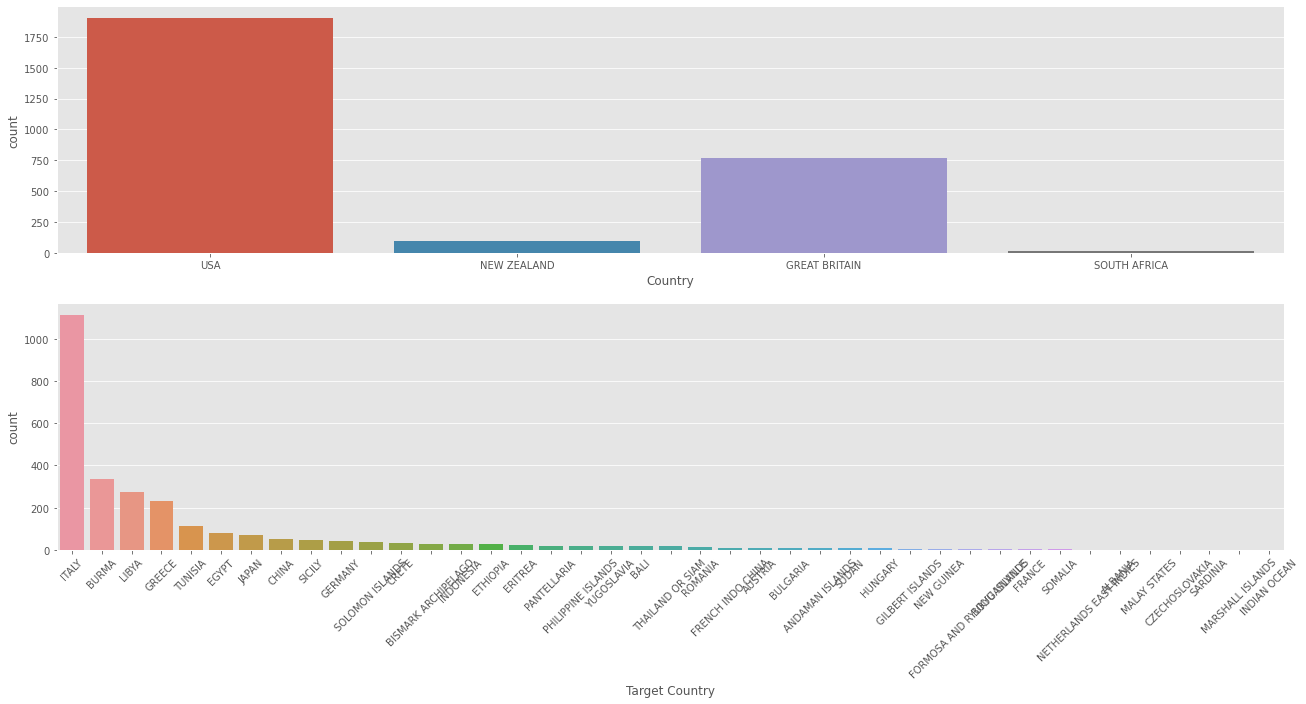

In [34]:
# Visualisation of countries with bombing missions
bombing_countries = aerial['Country'].value_counts()
fig = plt.figure(figsize=(22,10))
sns.countplot(data=aerial, x='Country',ax = plt.subplot(211))

# Count plot of 'Target' countries
sns.countplot(data=aerial, x='Target Country',order=aerial['Target Country'].value_counts().index, ax= plt.subplot(212))
plt.xticks(rotation=45)

#### Analysis
* The major attacking country was USA, while the target country was Italy.

#### Plotting geographical points using `plotly`

In [35]:
import plotly as py
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [36]:
data = aerial['Aircraft Series'].value_counts()
data = [go.Bar(x=data.index, y=data.values, hoverinfo='text', marker = dict(color = 'rgba(177, 14, 22, 0.5)'))]
layout = dict(title = 'Aircraft Series used for attack.',)
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

#### Attack Take Off locations

In [37]:
# attack take off locations
aerial["country_color"] = ""
aerial.country_color[aerial.Country == "USA"] = "blue"
aerial.country_color[aerial.Country == 'GREAT BRITAIN'] = "green"
aerial.country_color[aerial.Country == 'NEW ZEALAND'] = "orange"
aerial.country_color[aerial.Country == 'SOUTH AFRICA'] = "yellow"

data = [dict(type='scattergeo', lon = aerial['Takeoff Longitude'], lat = aerial['Takeoff Latitude'], 
             hoverinfo = 'text', text = 'Country:' + aerial.Country + " \nTakeoff Location: " + aerial['Takeoff Location'] + " \nTakeoff Base: "  + aerial["Takeoff Base"], 
        mode = 'markers', marker = dict(sizemode='area', sizeref=1, size = 10, line = dict(width=1, color = 'white'), color=aerial.country_color))]

layout = dict(title = "Locations of Aerial Attack Takeoff", hovermode = 'closest', 
              geo = dict(showcountries=True, showland=True, showcoastlines=True, countrywidth=1, landcolor='#a8b8ee' ))

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

#### Plotting target locations

In [38]:
# plotting target locations for bombing
data = [dict(type='scattergeo', lat=aerial['Target Latitude'], lon=aerial['Target Longitude'], 
             hoverinfo='text', text=aerial['Target Country'].fillna('N/A'),
            mode='markers',marker_symbol='circle-dot', marker_size=15, 
             marker = dict(sizemode='area', sizeref=1, size = 10, line = dict(width=1, color = 'white'), color='darkred'))]

layout = dict(title='Target latitude and longitude for bombing', hovermode='closest', 
              geo = dict(showcountries=True, showland=True, showcoastlines=True, countrywidth=1, landcolor='#a8b8ee'))

fig = go.Figure(data=data, layout=layout)
iplot(fig)

##### Analysis
* Major bombing actions occured in the Mediterrean Theater of War

#### Plotting the count of aerial bombing across various Theater of War

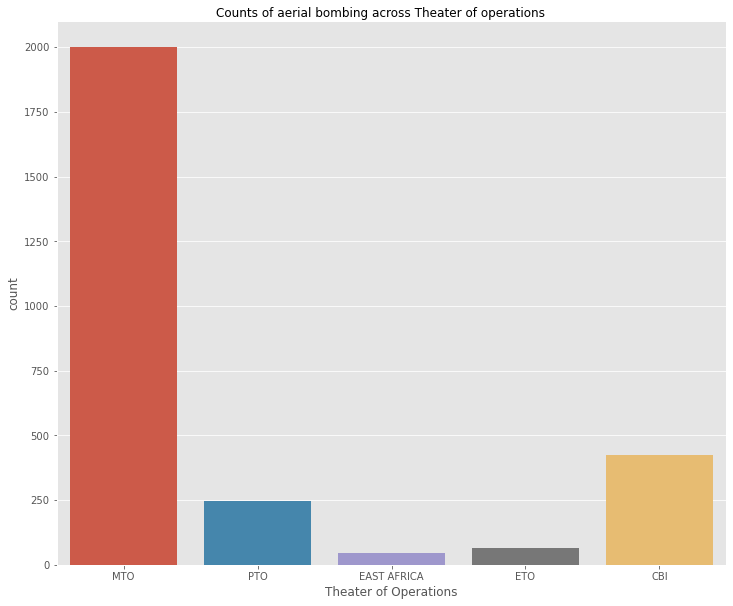

In [39]:
plt.figure(figsize=(12,10))
plt.suptitle('Counts of aerial bombing across Theater of operations', y=0.9)
sns.countplot(data=aerial, x='Theater of Operations')

#### Geoplot of weather station locations.

In [40]:
data = [dict(type='scattergeo', lat=stations_df['Latitude'], lon=stations_df['Longitude'], hoverinfo='text', text=stations_df.WBAN,
       mode='markers', marker_size=12, fillcolor='aliceblue',
        marker = dict(sizemode='area', sizeref=1, size = 15, line = dict(width=1, color = 'white')))]

layout = dict(title = "Locations of Weather Stations", hovermode = 'closest', 
              geo = dict(showcountries=True, showland=True, showcoastlines=True, countrywidth=1, landcolor='#a8b8ee'))

fig = go.Figure(data=data, layout=layout)
iplot(fig)

#### Understanding US-BURMA bombings.

* US constantly bombared BURMA from 1942-45. The closest weather stations are in ASSAM, INDIA.
* Weather station 32907, 32904, 32906.

In [41]:
station_id = weather[weather.STA.isin([32907, 32906, 32904])]

# convert 'Date' column to datetime
station_id['Date'] = pd.to_datetime(station_id['Date'])
print(station_id.Date.min())

# adding bombing dates to station_id df
burma_bombing = pd.DataFrame(aerial[aerial['Target Country'] == 'BURMA'])
burma_bombing = burma_bombing[['Mission ID', 'Mission Date', 'Country', 'Target Country', 'Target City']]

# converting burma_bombing['Mission Date'] to datetime
burma_bombing['Mission Date'] = pd.to_datetime(burma_bombing['Mission Date'])
burma_bombing = burma_bombing.loc[burma_bombing['Mission Date'] >= 'Jan 1943']
print(burma_bombing.head())

# # merging two dataframes on 'Date'
merged = pd.merge(station_id, burma_bombing, left_on='Date', right_on='Mission Date', how='outer')
print(merged.head(1))



1943-04-17 00:00:00
        Mission ID Mission Date Country Target Country     Target City
127726      128187   1943-01-16     USA          BURMA       MYITKYINA
136869      137330   1943-01-01     USA          BURMA  MYITNGE BRIDGE
136917      137378   1943-01-02     USA          BURMA          MONYWA
137271      137732   1943-01-04     USA          BURMA        MANDALAY
137273      137734   1943-01-04     USA          BURMA         RANGOON
      WBAN       NAME STATE/COUNTRY ID    LAT     LON  ELEV   Latitude  \
0  32907.0  BINDUKURI               IN  2643N  09248E  75.0  26.716667   

   Longitude      STA       Date  ... Snowfall    YR   MO    DA PRCP  \
0  92.716667  32907.0 1943-05-11  ...        0  43.0  5.0  11.0    0   

   Mission ID  Mission Date  Country Target Country  Target City  
0         NaN           NaT      NaN            NaN          NaN  

[1 rows x 24 columns]


Text(0.5, 1.0, "Mean temperature at station '32907'")

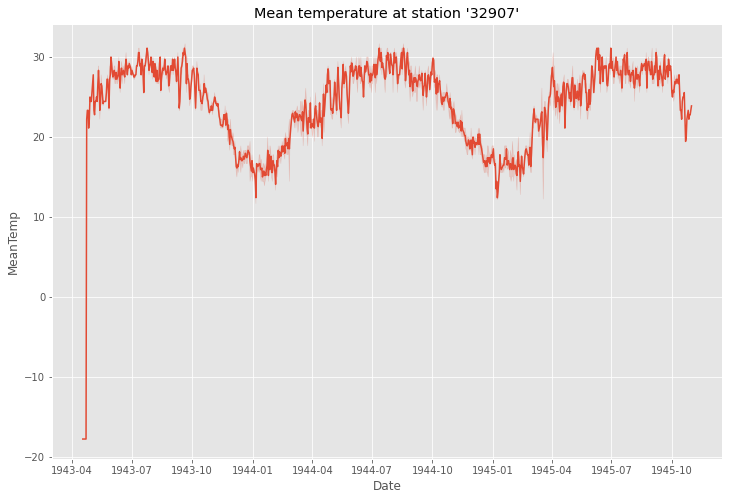

In [42]:
# plotting mean temperature
plt.figure(figsize=(12,8))
sns.lineplot(data=station_id, x='Date', y='MeanTemp')

plt.title("Mean temperature at station '32907'")

  Mission Date  Mission ID  Country  Target Country  Target City
0   1943-01-01           1        1               1            1
1   1943-01-02           1        1               1            1
2   1943-01-04           2        2               2            2
3   1943-01-07           2        2               2            2
4   1943-01-08           1        1               1            1


Text(0.5, 1.0, "Mean temperature at station '32907'")

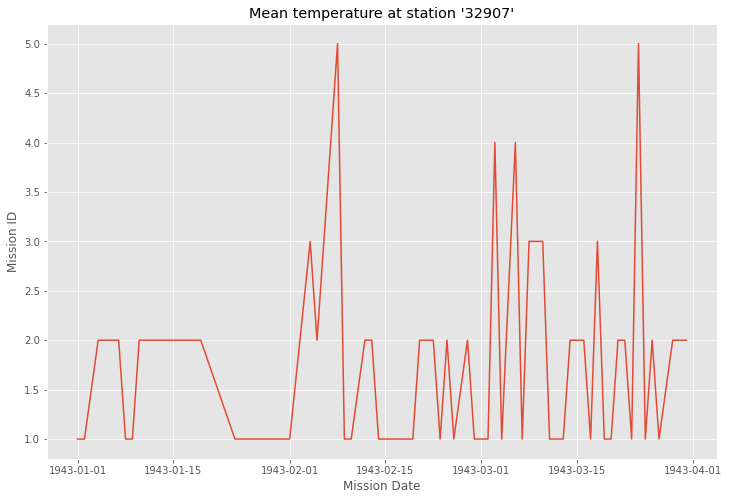

In [53]:
# grouping by Mission Dates
grouped_bur_bomb = burma_bombing.groupby('Mission Date').count()
grouped_bur_bomb = grouped_bur_bomb.reset_index()
print(grouped_bur_bomb.head())


plt.figure(figsize=(12,8))
sns.lineplot(data=grouped_bur_bomb, x='Mission Date', y='Mission ID')

plt.title("No of Bombing in 1943 on BURMA")